In [1]:
# Data-handling imports
import pandas as pd
import numpy as np
import eda

# Text-handling imports
import spacy

# Other imports
from progress import show_progress
import matplotlib.pyplot as plt
import plotstyle
import seaborn as sns
import re

# Options
freq_col = "freq_per_100000"

# Read in data

## Essays

In [2]:
# Read in essay and score data
essays = pd.read_csv("../data_private/train.tsv", sep="\t")
subset = essays[(essays["essay_set"] == 3) | (essays["essay_set"] == 4)].reset_index()

## NLP data

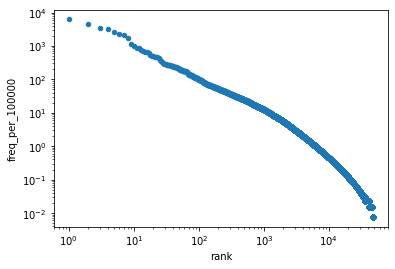

In [3]:
# Read in American English word frequency list
freqs = pd.read_csv("../data/anc_frequency_list.csv")

# Merge homonyms, as they won't affect the analysis much
freqs = pd.DataFrame(freqs.groupby("lemma")[freq_col].sum())

# Add rank
freqs["rank"] = freqs[freq_col].rank(method="min", ascending=False).astype(int)

# Demonstrate Zipf's Law on the frequency list as a sanity check
freqs.plot.scatter("rank", freq_col, loglog=True);

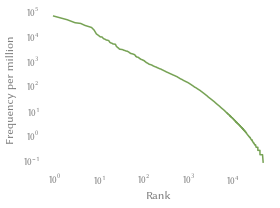

In [7]:
plt.figure(figsize=(4, 3))
ax = plt.gca()

freqs["permil"] = freqs[freq_col] * 10

# Demonstrate Zipf's Law on the frequency list as a sanity check
freqs.sort_values("rank").plot("rank", "permil", loglog=True, ax=ax, color=plotstyle.palette[0], legend=False);
ax = plotstyle.setup("", "Rank", "Frequency per million", ax=ax)

plt.tight_layout()
plt.savefig("../graphs/anc_zipf.svg", transparent=True)

In [62]:
# Words that signal a transition from one paragraph to another. Sources:
# <https://en.wiktionary.org/wiki/Category:English_conjunctive_adverbs>
# <https://en.wiktionary.org/wiki/Category:English_sequence_adverbs>
with open("../data/english-linking-words.txt") as file:
    linking_words = file.read().split("\n")[:-1] # drop final newline

In [63]:
# Initialize spaCy
nlp = spacy.load('en')

# EDA
## Overview

In [64]:
eda.summary.summary(essays)

,0,1,2,3,4,type,nulls,count,mean,std,min,25%,50%,75%,max
essay_id,1,2,3,4,5,int64,0,12976.0,10295.395808,6309.074105,1.0,4438.75,10044.5,15681.25,21633.0
essay_set,1,1,1,1,1,int64,0,12976.0,4.179485,2.136913,1.0,2.00,4.0,6.00,8.0
essay,"Dear local newspaper, I think effects computer...","Dear @CAPS1 @CAPS2, I believe that using compu...","Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...","Dear Local Newspaper, @CAPS1 I have found that...","Dear @LOCATION1, I know having computers has a...",object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rater1_domain1,4,5,4,5,4,int64,0,12976.0,4.127158,4.212544,0.0,2.00,3.0,4.00,30.0
rater2_domain1,4,4,3,5,4,int64,0,12976.0,4.137408,4.264330,0.0,2.00,3.0,4.00,30.0
rater3_domain1,NaN,NaN,NaN,NaN,NaN,float64,12848,128.0,37.828125,5.240829,20.0,36.00,40.0,40.00,50.0
domain1_score,8,9,7,10,8,int64,0,12976.0,6.800247,8.970705,0.0,2.00,3.0,8.00,60.0
rater1_domain2,NaN,NaN,NaN,NaN,NaN,float64,11176,1800.0,3.333889,0.729103,1.0,3.00,3.0,4.00,4.0
rater2_domain2,NaN,NaN,NaN,NaN,NaN,float64,11176,1800.0,3.330556,0.726807,1.0,3.00,3.0,4.00,4.0
domain2_score,NaN,NaN,NaN,NaN,NaN,float64,11176,1800.0,3.333889,0.729103,1.0,3.00,3.0,4.00,4.0


## Missing data

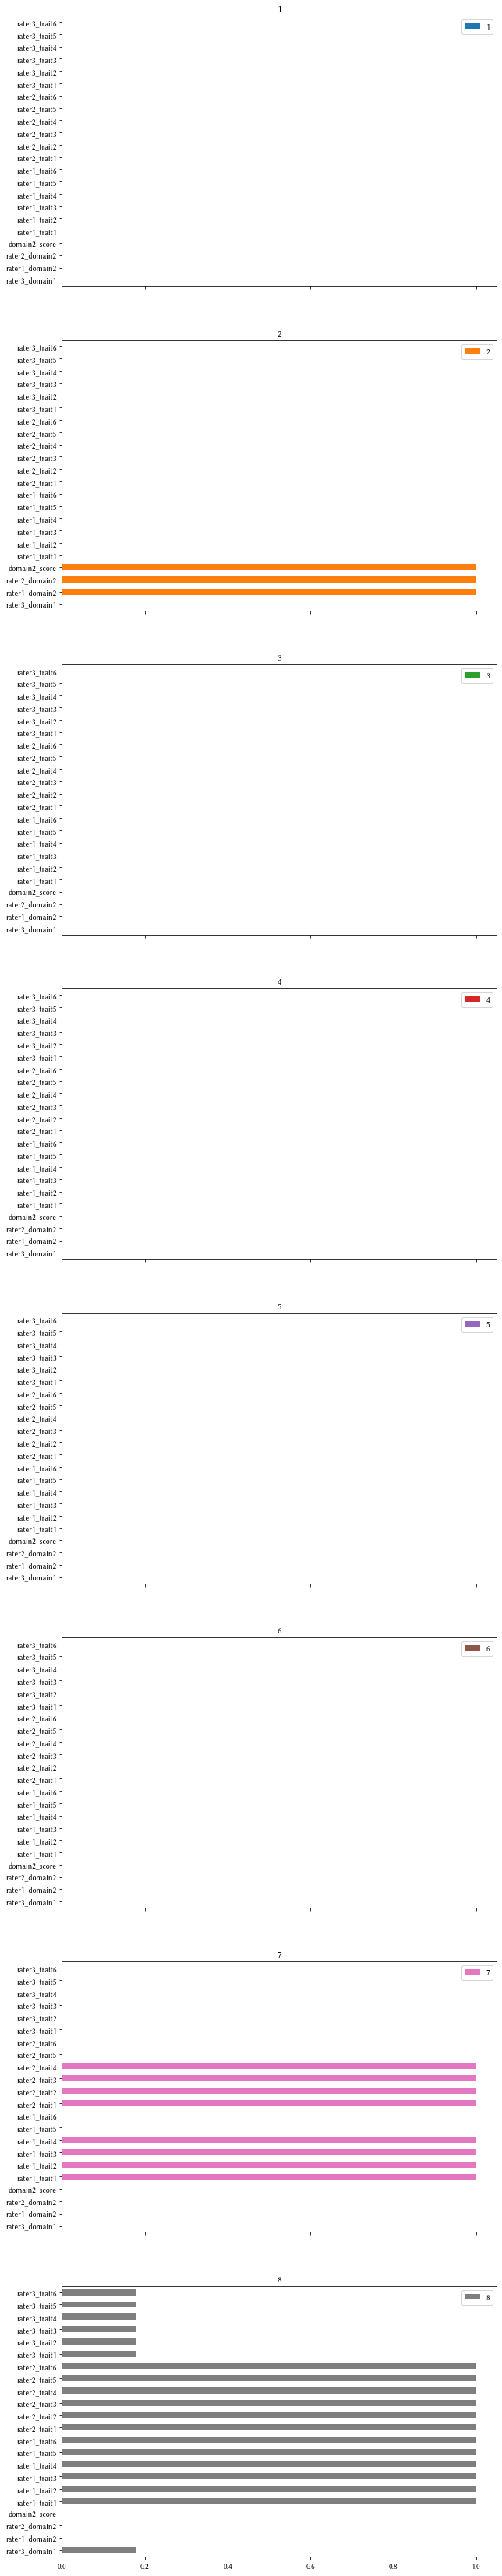

In [65]:
# Columns in which a majority of data is missing
missing_cols = essays.columns[essays.isna().mean() >= 0.5]

# We use `notna` rather than `isna` because most of these categories are only defined for a handful of sets
essays[missing_cols].notna().groupby(essays["essay_set"]).mean().T.plot.barh(figsize=(10, 60), subplots=True);

**Summary of missing data:**

* Only essay set 2 contains `domain2_score`, `rater1_doman1`, and `rater2_domain2`.
* Only essays sets 7 and 8 contain `rater{1..2}_trait{1..4}`.
* Only essay set 8 contains `rater3_domain1`, `rater{1..2}_trait{5..6}`, and `rater3_trait{1..6}`.

## Domains & Traits

In [66]:
domain_cols = [
    "rater1_domain1",
    "rater1_domain2",
    "rater2_domain1",
    "rater2_domain2",
    "rater3_domain1",
]

trait_cols = [
    "rater1_trait1",
    "rater1_trait2",
    "rater1_trait3",
    "rater1_trait4",
    "rater1_trait5",
    "rater1_trait6",

    "rater2_trait1",
    "rater2_trait2",
    "rater2_trait3",
    "rater2_trait4",
    "rater2_trait5",
    "rater2_trait6",

    "rater3_trait1",
    "rater3_trait2",
    "rater3_trait3",
    "rater3_trait4",
    "rater3_trait5",
    "rater3_trait6",
]

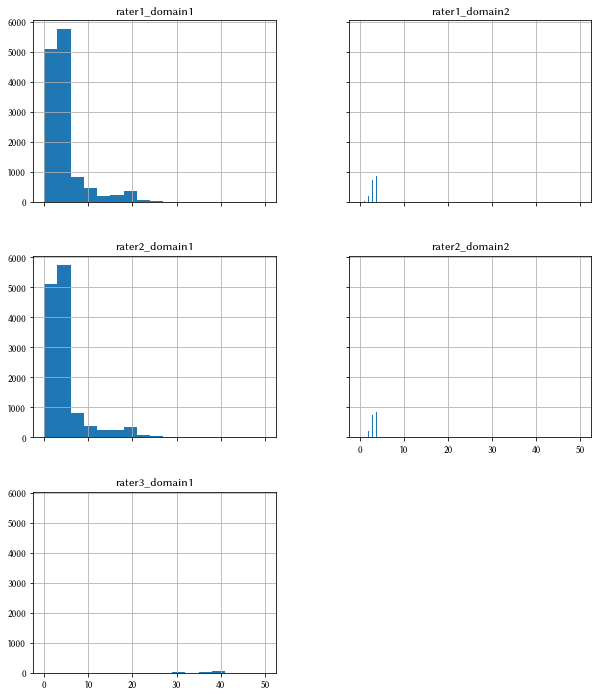

In [67]:
essays.hist(column=domain_cols, figsize=(10, 12), sharex=True, sharey=True);

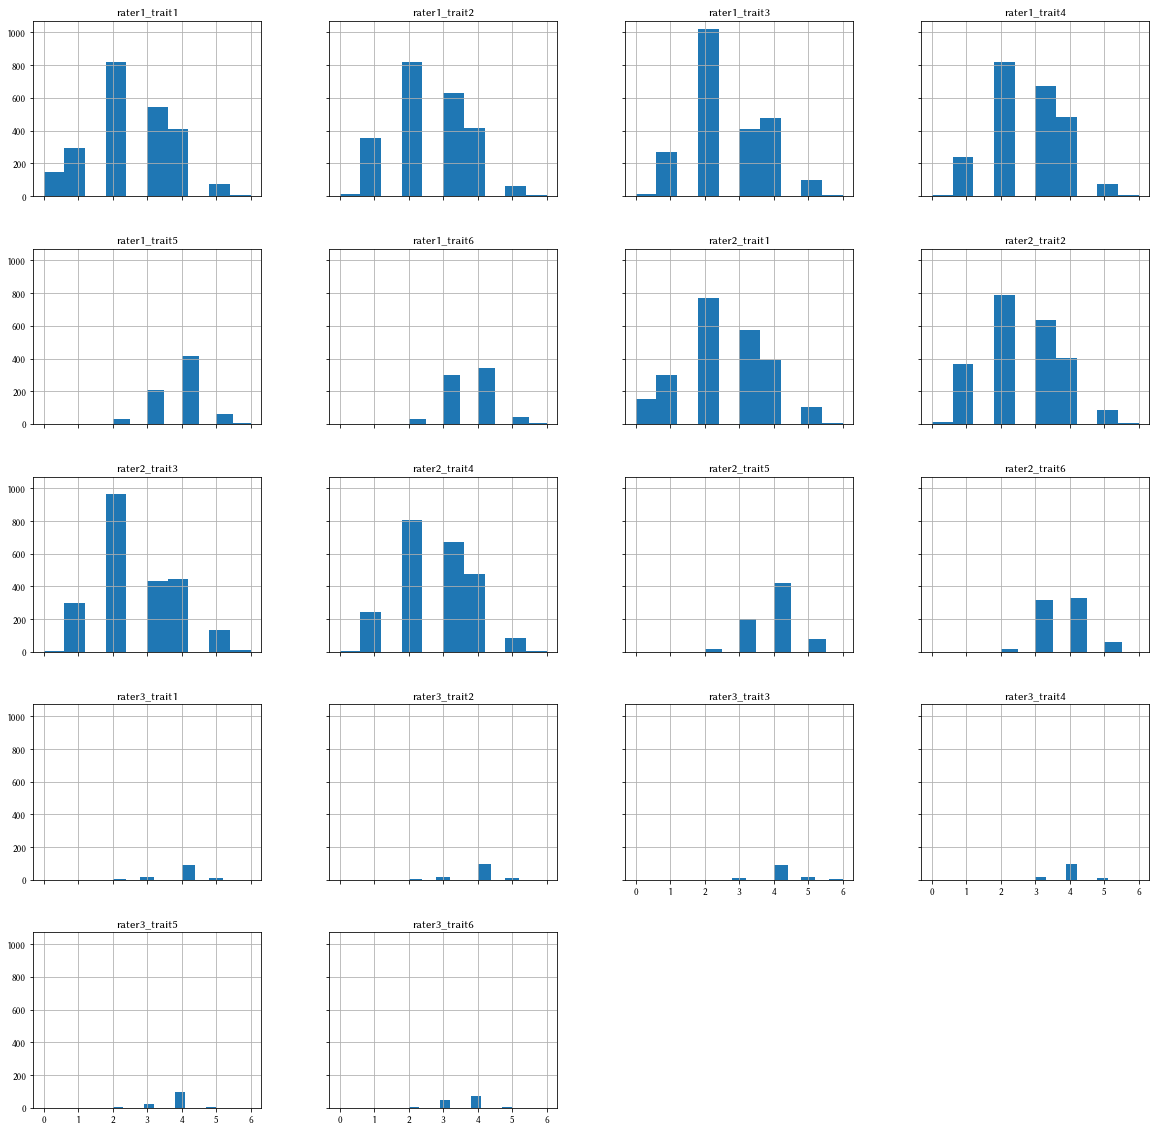

In [68]:
essays.hist(column=trait_cols, figsize=(20, 20), sharex=True, sharey=True);

## Score distribution

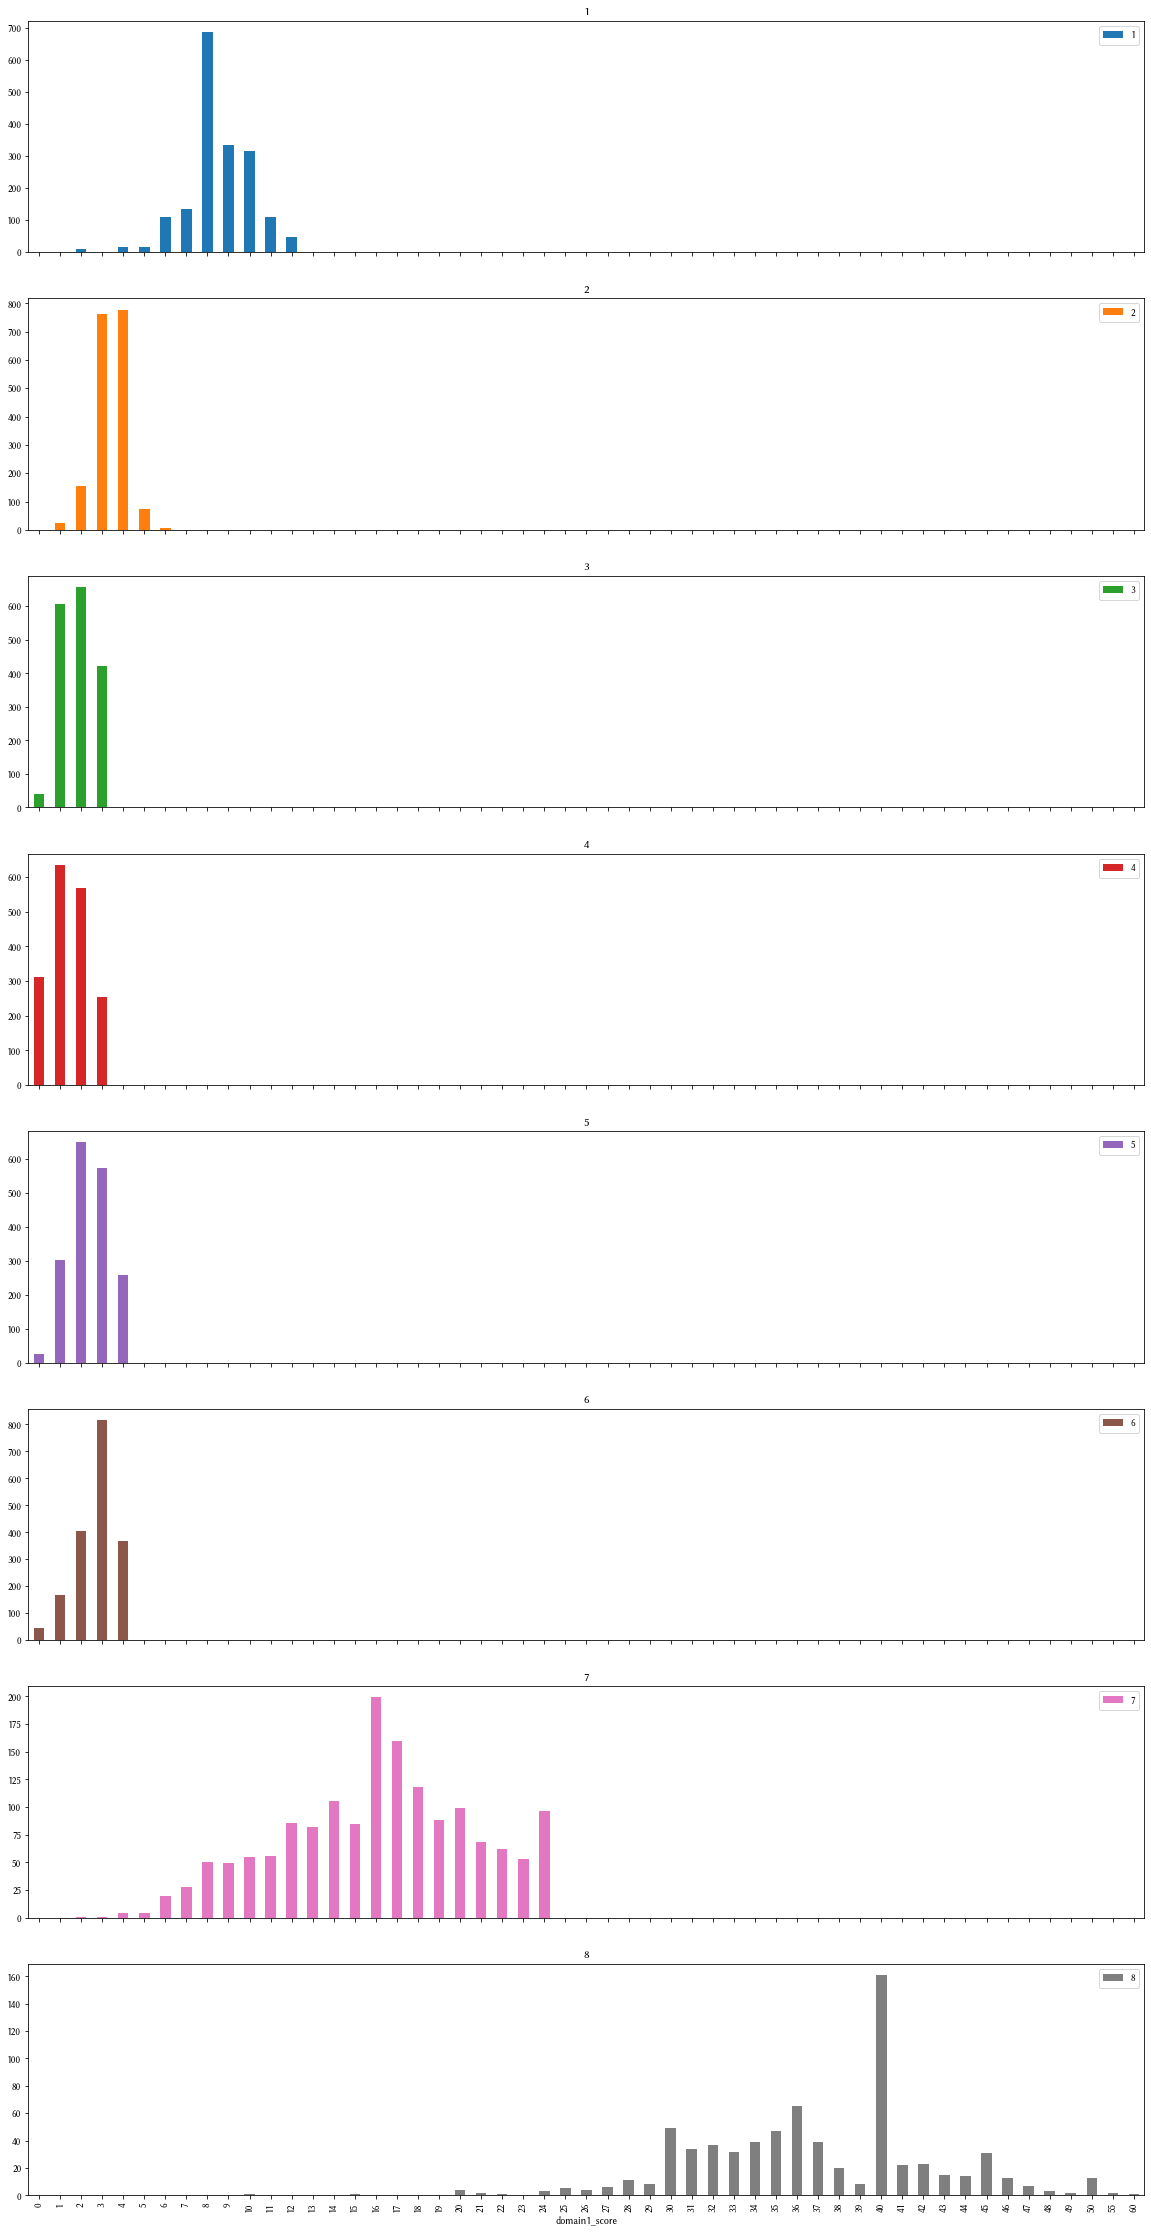

In [69]:
# Show distribution of scores by essay set
essays.groupby(["essay_set", "domain1_score"])["essay_id"].count().unstack().T.plot.bar(subplots=True, figsize=(20, 40));

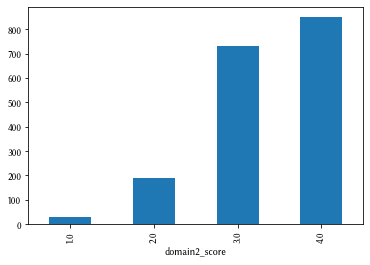

In [70]:
essays[essays["essay_set"] == 2].groupby("domain2_score")["essay_id"].count().plot.bar();

# Define metrics

In [71]:
def freq_score(doc):
    """Calculates an arbitrarily-defined "frequency metric"
    that tries to capture how many infrequent words are used
    in the text."""
    l = []
    score = 0
    known_words = 0
    for word in doc:
        lemma = word.lemma_
        try:
            score += (freqs.loc[lemma, "rank"])
            l.append((lemma, freqs.loc[lemma, "rank"]))
            known_words += 1
        except KeyError:
            pass
    return score

def freq_graph(doc):
    """Calculates an arbitrarily-defined "frequency metric"
    that tries to capture how many infrequent words are used
    in the text."""
    lemmas = set([word.lemma_ for word in doc if word.lemma_ in freqs.index])
    plt.figure()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(freqs["rank"].min(), freqs["rank"].max())
    plt.scatter("rank", freq_col, data=freqs.loc[lemmas, :], color="red");
    plt.text(x=freqs.loc[lemmas, :]["rank"], y=freqs.loc[lemmas, :][freq_col], s=lemmas)
    
# Demonstrate "frequency metric" on some sample sentences
sents = [
    "I am he as you are he as you are me and we are all together.",
    "Once upon a midnight dreary, while I pondered, weak and weary",
    "In Xanadu did Kubla Khan a stately pleasure-dome decree",
    "We shall fight on the beaches.",
    "The cat sat on the mat.",
    "The boy stood on the burning deck whence all but he had fled.",
    "In a hole in the ground, there lived a hobbit.",
    "'Twas brillig, and the slithy toves did gyre and gimble in the wabe."
]

sents = [
    "Because I could not stop for Death, he kindly stopped for me.",
    "The boy stood on the burning deck whence all but he had fled.",
    "I was the shadow of the waxwing slain by the false azure in the windowpane.",
    "'Twas brillig, and the slithy toves did gyre and gimble in the wabe."
]

for sent in sents:
    s = nlp(sent)
    print(freq_score(s))
    #freq_graph(s)

9164
23815
86636
146103


# Compute metrics

## NLP metrics

In [72]:
def is_word(w):
    return (not w.is_space) and (not w.is_punct)


@show_progress
def parse_essays(i, essay):
    # Compute various metrics:
    doc = nlp(essay)

    # Document vector
    essays.loc[i, essays.columns.str.startswith("vec")] = doc.vector
    
    # L2-normed document vector
    #essays.loc[i, "vec_norm"] = doc.vector_norm
    
    # Token count
    essays.loc[i, "tokens"] = len(list(filter(is_word, doc)))

    # Type count (may be inflated by misspellings)
    essays.loc[i, "types"] = len(set([word.lemma_ for word in doc if is_word(word)]))
    
    # Mean sentence length
    essays.loc[i, "sent_len"] = np.mean([len(list(filter(is_word, s))) for s in doc.sents])
    
    # Mean word length
    essays.loc[i, "word_len"] = np.mean(list(map(len, filter(is_word, doc))))
    
    # Word frequency measure
    essays.loc[i, "freq"] = freq_score(doc)

    # Semicolons per token
    essays.loc[i, "semicolons"] = len([token for token in doc if token.text == ";"]) / essays.loc[i, "tokens"]
    
    # Linking words per token
    essays.loc[i, "link_words"] = sum([len(re.findall(f"\\b{link}\\b", essay)) for link in linking_words]) / essays.loc[i, "tokens"]
    
    # Number of prepositional phrases per token
    essays.loc[i, "pps"] = len([tok.pos_ == "ADP" for tok in doc]) / essays.loc[i, "tokens"]
    
    # Depth of longest branch in dependency tree
    essays.loc[i, "max_depth"] = max([len(list(tok.children)) for tok in doc])

In [98]:
for i in range(96):
    essays["vec" + str(i)] = np.nan

parse_essays(essays["essay"])

Parsing item 1,969 of 12,976 [=====>                         ] 15%, 38:45 remains...


KeyboardInterrupt: 

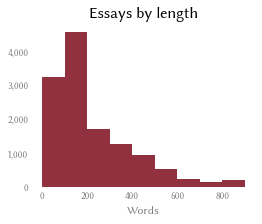

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plotstyle.setup("Essays by length", "Words", "", xformat="{x:,.0f}", yformat="{x:,.0f}", ax=ax)
ax.hist(essays["tokens"], color=plotstyle.palette[4], bins=range(0, 1000, 100));
plt.savefig("../graphs/length.svg", transparent=True, bbox_inches="tight")

## Grade level

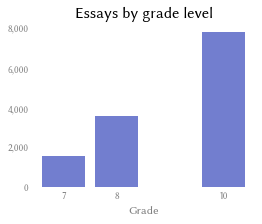

In [86]:
essays["grade_level"] = essays["essay_set"].map({
    1: 8,
    2: 10,
    3: 10,
    4: 10,
    5: 8,
    6: 10,
    7: 7,
    8: 10,
})

grade_counts = essays.groupby("grade_level").count()["essay_id"]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plotstyle.setup("Essays by grade level", "Grade", "", xformat="{x:,.0f}", yformat="{x:,.0f}", ax=ax)
ax.set_xticks(grade_counts.index)
ax.bar(grade_counts.index, grade_counts, color=plotstyle.palette[1]);
plt.savefig("../graphs/grades.svg", transparent=True, bbox_inches="tight")

# Compute scores

In [87]:
# If only one score exists, use that. Otherwise, take the mean of both scores.
essays["score"] = list(map(np.nanmean, zip(essays["domain1_score"], essays["domain2_score"])))

# Compute correlations

In [94]:
meta_cols = [
    "tokens",
    "types",
    "sent_len",
    "word_len",
    "freq",
    "semicolons",
    "link_words",
    "pps",
    "max_depth"
]

subset = essays[(essays["essay_set"] == 3) | (essays["essay_set"] == 4)]
subset[[*meta_cols, "score"]].corr()

,tokens,types,sent_len,word_len,freq,semicolons,link_words,pps,max_depth,score
tokens,1.000000,0.959447,0.037327,0.095287,0.790111,0.065656,0.034291,0.232094,0.494486,0.720707
types,0.959447,1.000000,0.028336,0.140389,0.804711,0.081101,0.041024,0.272947,0.499774,0.731480
sent_len,0.037327,0.028336,1.000000,0.065025,-0.003718,0.018723,-0.010781,-0.231905,0.192806,-0.024511
word_len,0.095287,0.140389,0.065025,1.000000,0.286905,0.034074,-0.051076,0.167177,0.070147,0.159916
freq,0.790111,0.804711,-0.003718,0.286905,1.000000,0.055009,-0.028215,0.300611,0.410907,0.629898
semicolons,0.065656,0.081101,0.018723,0.034074,0.055009,1.000000,-0.005786,0.064863,0.066837,0.061972
link_words,0.034291,0.041024,-0.010781,-0.051076,-0.028215,-0.005786,1.000000,-0.026997,0.016461,0.019020
pps,0.232094,0.272947,-0.231905,0.167177,0.300611,0.064863,-0.026997,1.000000,0.317544,0.253382
max_depth,0.494486,0.499774,0.192806,0.070147,0.410907,0.066837,0.016461,0.317544,1.000000,0.366230
score,0.720707,0.731480,-0.024511,0.159916,0.629898,0.061972,0.019020,0.253382,0.366230,1.000000


# Write out

In [97]:
# Columns in which no values are missing
complete_cols = essays.columns[essays.notna().all()]

# Sets with no additional columns
for i in [1,3,4,5,6]:
    essays[essays["essay_set"] == i][complete_cols]\
    .to_csv(f"../data_private/essays_cleaned_set_{i}.csv", index=False)

# Sets with additional columns
extra_cols = {
    2: ["domain2_score", "rater1_domain1", "rater2_domain2"],
    7: [f"rater{i}_trait{j}" for i in range(1,3) for j in range(1,5)],
    8: [f"rater{i}_trait{j}" for i in range(1,4) for j in range(1,7)]
}

# Write out individual sets
for i in [2,7,8]:
    essays[essays["essay_set"] == i][[*complete_cols, *extra_cols[i]]]\
    .to_csv(f"../data_private/essays_cleaned_set_{i}.csv", index=False)

# Write out complete corpus
essays[complete_cols].to_csv("../data_private/essays_cleaned.csv", index=False)

# Write out target set of interest to this project
essays[(essays["essay_set"] == 3) | (essays["essay_set"] == 4)].reset_index(drop=True)\
.to_csv("../data_private/essays_cleaned_target.csv", index=False)

# References

Monroe, Burt L., Michael P. Colaresi, and Kevin M. Quinn. 2008. “Fightin’ Words: Lexical Feature Selection and Evaluation for Identifying the Content of Political Conflict.” *Political Analysis* 16 (4): 372–403. doi:[10.1093/pan/mpn018](https://doi.org/10.1093/pan/mpn018).